## Exploring Stock Market Dynamics with Geometric Brownian Motion: A Python Simulation

https://quantjourney.substack.com/p/exploring-stock-market-dynamics-with

/home/tikam/stock-market/env3/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


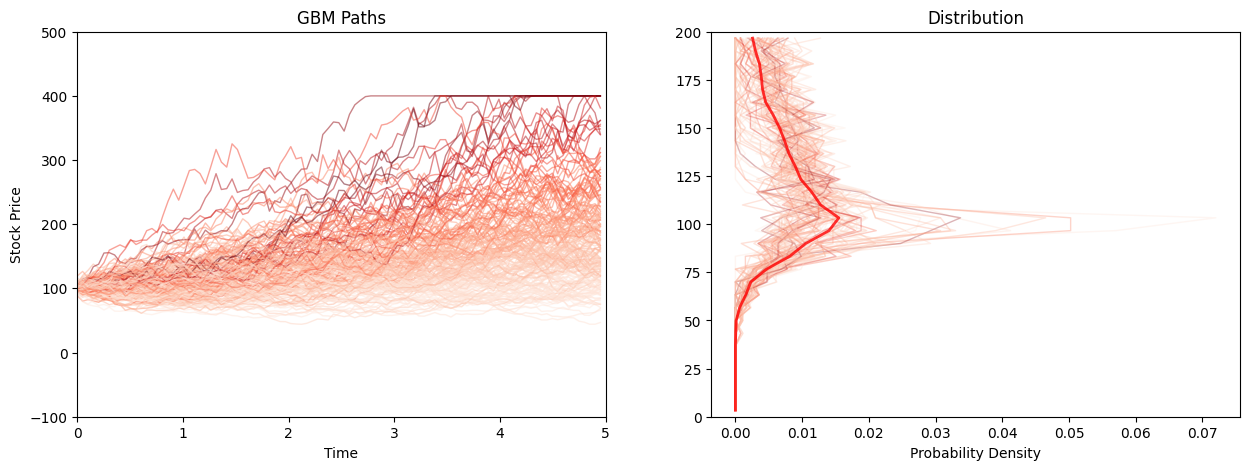

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import yfinance as yf
import pandas as pd

# Parameters
NO_OF_PATHS = 200
NO_OF_TIME_STEPS = 100
TIME_STEP_SIZE = 0.05
DRIFT = 0.1  # Slight drift
VOLATILITY = 0.05  # Reduced volatility
S0 = 100  # Initial stock price
T = NO_OF_TIME_STEPS * TIME_STEP_SIZE  # Total time

def fetch_spy_data(start_date, end_date):
    spy = yf.Ticker("FCL.NS")
    data = spy.history(start=start_date, end=end_date)
    return data['Close']

def calculate_historical_volatility_series(paths, dt):
    log_returns = np.diff(np.log(paths), axis=0)
    volatility_series = np.std(log_returns, axis=1) * np.sqrt(1 / dt)
    return volatility_series

def test_convergence(S0, mu, sigma, T, dt_values, N):
    results = {}
    for dt in dt_values:
        paths, _ = simulate_gbm(S0, mu, sigma, T, dt, N)
        volatility = calculate_historical_volatility_series(paths, dt)
        results[dt] = volatility
    return results

def get_distribution_data(prices, bins=30, density=True, range=(0, 200)):
    counts, bin_edges = np.histogram(prices, bins=bins, density=density, range=range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, counts

def simulate_gbm(S0, drift, sigma, T, dt, N):
    num_steps = int(T / dt)
    t = np.linspace(0, T, num_steps)
    W = np.random.standard_normal(size=(num_steps, N))
    W = np.cumsum(W, axis=0)  # Cumulative sum to simulate Brownian motion
    X = (drift - 0.5 * sigma**2) * t[:, np.newaxis] + sigma * W
    S = S0 * np.exp(X)
    return np.clip(S, 0, 400), t  # Clip the stock prices for visualization

# Initialize an array to accumulate the data
accumulated_data = np.array([])

# Simulate GBM
simulated_paths, time = simulate_gbm(S0, DRIFT, VOLATILITY, T, TIME_STEP_SIZE, NO_OF_PATHS)

# Call the animator
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjusted for 2 subplots

ax1.set_xlim(0, T)
ax1.set_ylim(0, 400)  # Set y-axis limits
ax1.set_xlabel('Time')
ax1.set_ylabel('Stock Price')
ax1.set_title('GBM Paths')

ax2.set_xlabel('Probability Density')
ax2.set_ylabel('Stock Price')
ax2.set_title('Cumulative Distribution of Prices')
ax2.set_ylim(0, 400)  # Set y-axis limits for the histogram

def init():
    ax1.plot([], [], lw=2)
    ax2.hist([], bins=30, orientation='horizontal', alpha=0.7, color='blue', density=True, range=(0, 200))
    return fig,

def animate(i):
    global accumulated_data
    ax1.clear()
    ax1.set_xlim(0, T)
    ax1.set_ylim(-100, 500)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Stock Price')
    ax1.set_title('GBM Paths')
    # Plot paths with color mapping
    for j in range(NO_OF_PATHS):
        ax1.plot(time[:max(1, i)], simulated_paths[:max(1, i), j], color=colors[j], lw=1, alpha=0.5)
    
    ax2.clear()
    ax2.set_xlabel('Probability Density')
    ax2.set_title('Distribution')
    ax2.set_ylim(0, 200)
    # Plot distribution for each time step
    for k in range(1, max(2, i)):
        bin_centers, counts = get_distribution_data(simulated_paths[k-1], bins=30, density=True, range=(0, 200))
        ax2.plot(counts, bin_centers, color=colors[k], lw=1, alpha=0.3)  # Lighter alpha for individual distributions

    # Plot cumulative distribution
    if i > 0:
        accumulated_data = np.append(accumulated_data, simulated_paths[i-1])
        bin_centers, counts = get_distribution_data(accumulated_data, bins=30, density=True, range=(0, 200))
        ax2.plot(counts, bin_centers, color='red', lw=2, alpha=0.8)  # More prominent for cumulative distribution

    return fig

# Convergence and Grid Tests
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]
convergence_results = test_convergence(S0, DRIFT, VOLATILITY, T, dt_values, NO_OF_PATHS)

# Calculate color mapping
mean_path = np.mean(simulated_paths, axis=1)
colors = cm.Reds(np.std(simulated_paths, axis=0) / np.std(simulated_paths, axis=0).max())

# Start and end dates for fetching real data
start_date = '2022-01-01'  
end_date = '2024-02-15'

# Fetch real SPY data
real_spy_data = fetch_spy_data(start_date, end_date)

# Interpolate SPY data to fill missing dates
real_spy_data_interpolated = real_spy_data.reindex(pd.date_range(start_date, end_date, freq='D')).interpolate()

# Normalize or scale SPY data
spy_initial = real_spy_data_interpolated.iloc[0]
real_spy_data_scaled = (real_spy_data_interpolated / spy_initial) * S0

# Call the animator
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=NO_OF_TIME_STEPS, interval=100, repeat=False)

# Create an FFMpegWriter object directly without relying on the registry
writer = animation.FFMpegWriter(fps=15, metadata=dict(artist='Your Name'), bitrate=1800, codec="libx264")

# Save the animation
ani.save('ml_gbm_animation.mp4', writer=writer)

# Display the animation (if you want to show it in Jupyter Notebook, for example)
plt.show()
